In [15]:
#import stock
import pandas as pd 
data= pd.read_csv(r'C:\Users\Wenlei\Desktop\GQP\vinix_all.csv')  #stock data can be download from yahoo finance historical data tab
data.head()

Date       Open       High        Low      Close  Adj Close  Volume
0  1990-07-31  34.099998  34.099998  34.099998  34.099998  17.192333       0
1  1990-08-01  34.040001  34.040001  34.040001  34.040001  17.162085       0
2  1990-08-02  33.660000  33.660000  33.660000  33.660000  16.970497       0
3  1990-08-03  33.029999  33.029999  33.029999  33.029999  16.652859       0
4  1990-08-06  32.060001  32.060001  32.060001  32.060001  16.163826       0

In [16]:
#create a function to make data Finta library compatibile so that I can use Finta library to create indicator
def getFintaCompatibleData():
    df = data.copy()   # get a copy
    df = df[['Date','Open', 'High', 'Low', 'Adj Close','Volume']] #only use adj close, since stock often split
    df.columns = ['date', 'open', 'high', 'low', 'close', 'volume'] #rename adj close to close to be used in finta
    df['next close'] = df['close'].shift(-1) #get next day price
    return df
df= getFintaCompatibleData()
df.head()

date       open       high        low      close  volume  next close
0  1990-07-31  34.099998  34.099998  34.099998  17.192333       0   17.162085
1  1990-08-01  34.040001  34.040001  34.040001  17.162085       0   16.970497
2  1990-08-02  33.660000  33.660000  33.660000  16.970497       0   16.652859
3  1990-08-03  33.029999  33.029999  33.029999  16.652859       0   16.163826
4  1990-08-06  32.060001  32.060001  32.060001  16.163826       0   16.189018

In [17]:
#create function that I can pass in dataframe and add indicator value 
#with indicator value, given certain cutoff, I can get buy, sell, and hold signal, let us give it 1, -1, 0
from finta import TA


#help function to get buy, sell, hold signal for single indidator
def GiveSignalforSingleIncidator (row, indicator, low, high):
    if row[indicator]<low:
        return 1
    elif row[indicator]>high:
        return -1
    else:
        return 0

#function to get indicator value and signal for single indicator

def GiveSignalforSingleIncidator2 (df, indicator, function, period, low, high):
    df = df.copy(deep = True)     #get a copy not affect orignal df
    df[indicator]= function(df, period)  #create indicator
    #df = filteroutIncompleteRecord (df, indicator)   #filter incomplete data
    df[indicator +' signal'] = df.apply(GiveSignalforSingleIncidator,args=(indicator, low, high), axis =1)  #create indiator predict price trend
    return df

#test1
df_test = GiveSignalforSingleIncidator2 (df, 'RSI', TA.RSI, 14, 30, 70)
df_test.tail()

date        open        high         low       close  volume  \
7592  2020-09-17  300.519989  300.519989  300.519989  300.519989       0   
7593  2020-09-18  297.170013  297.170013  297.170013  297.170013       0   
7594  2020-09-21  293.739990  293.739990  293.739990  293.739990       0   
7595  2020-09-22  296.829987  296.829987  296.829987  296.829987       0   
7596  2020-09-23  289.809998  289.809998  289.809998  289.809998       0   

      next close        RSI  RSI signal  
7592  297.170013  46.875634           0  
7593  293.739990  43.099228           0  
7594  296.829987  39.582976           0  
7595  289.809998  44.014298           0  
7596         NaN  37.317730           0

In [18]:
#create another type of feature, which use cross for buy, sell signal, for example simple moving average, EMA
def GiveSignalforCrossOver (row):
    if row['fast']>row['slow'] and row['previous fast'] <row['previous slow']:  #define fast moving average cross over slow one
        return 1
    elif row['fast']<row['slow'] and row['previous fast'] >row['previous slow']: #define fast moving average cross under slow one
        return -1
    else:
        return 0

def GiveSignalforCrossOver2 (df, indicator, function, fast, slow):
    df = df.copy(deep = True)
    df['fast'] = function(df, fast)
    df['slow'] = function(df, slow)
    df['previous fast'] = df['fast'].shift() 
    df['previous slow'] = df['slow'].shift() 
    df[indicator +' signal'] = df.apply(GiveSignalforCrossOver, axis =1)
    df= df.drop (['fast', 'slow', 'previous fast', 'previous slow'], axis =1)
    return df

#test1
df_test2 = GiveSignalforCrossOver2 (df, 'SMA', TA.SMA, 50, 200)
df_test2.head()

date       open       high        low      close  volume  next close  \
0  1990-07-31  34.099998  34.099998  34.099998  17.192333       0   17.162085   
1  1990-08-01  34.040001  34.040001  34.040001  17.162085       0   16.970497   
2  1990-08-02  33.660000  33.660000  33.660000  16.970497       0   16.652859   
3  1990-08-03  33.029999  33.029999  33.029999  16.652859       0   16.163826   
4  1990-08-06  32.060001  32.060001  32.060001  16.163826       0   16.189018   

   SMA signal  
0           0  
1           0  
2           0  
3           0  
4           0

In [19]:
'''
creat a custom class so that I can use it for pipeline and ML grid search for best param
the class can handle different type of indicator, for example single indicator or crossover indicator
class generate final dataframe for ML.
in this case, I only keep feature I think it is important, it might not right, but the goal is to show technically how to achieve
'''
#create needed signal   include close, rsi and signal
from sklearn.base import BaseEstimator, TransformerMixin
class CreateSignal (BaseEstimator, TransformerMixin):
    def __init__(self, indicator = 'RSI', function = TA.RSI, period = 14, low = 30, high = 70, fast =50, slow =200
                ): # give default value, but value can change based on passed in param
        self.indicator = indicator
        self.function = function
        self.period = period
        self.low =low 
        self.high =high
        self.fast =fast
        self.slow = slow

    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        if self.indicator in ['RSI','TRIX', 'ER',  'CCI', 'STOCHRSI', 'WILLIAMS']: # a group single indicator 
            X= GiveSignalforSingleIncidator2 (X, self.indicator, self.function, self.period, self.low, self.high)  #use function
        if self.indicator in ['SMA', 'SMM', 'SSMA', 'EMA', 'DEMA', 'TEMA', 'TRIMA', 'TRIX', 'VAMA',
       'KAMA', 'ZLEMA', 'WMA', 'HMA', 'EVWMA', 'SMMA',]: #cross indicators
            X = GiveSignalforCrossOver2 (X, self.indicator, self.function, self.fast, self.slow)
            
        return X.drop(['open','high', 'low','date', 'volume' ], axis=1)  # only return needed column  



In [20]:
#test if class work 
CS = CreateSignal ( 'RSI', TA.RSI, 14, 30, 70 )
df_test2 = CS.fit_transform(df)
print(df_test2.shape)
df_test2.head()

(7597, 4)


close  next close  RSI  RSI signal
0  17.192333   17.162085  NaN           0
1  17.162085   16.970497  0.0           1
2  16.970497   16.652859  0.0           1
3  16.652859   16.163826  0.0           1
4  16.163826   16.189018  0.0           1

In [21]:
CS3 = CreateSignal ( 'SMA', TA.SMA, 50, 200 )
df_test3 = CS3.fit_transform(df)
print(df_test3.shape)
df_test3.head()

(7597, 3)


close  next close  SMA signal
0  17.192333   17.162085           0
1  17.162085   16.970497           0
2  16.970497   16.652859           0
3  16.652859   16.163826           0
4  16.163826   16.189018           0

## preprocess data to be used for machine learning

In [22]:
df.head()

date       open       high        low      close  volume  next close
0  1990-07-31  34.099998  34.099998  34.099998  17.192333       0   17.162085
1  1990-08-01  34.040001  34.040001  34.040001  17.162085       0   16.970497
2  1990-08-02  33.660000  33.660000  33.660000  16.970497       0   16.652859
3  1990-08-03  33.029999  33.029999  33.029999  16.652859       0   16.163826
4  1990-08-06  32.060001  32.060001  32.060001  16.163826       0   16.189018

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001BE36808100>,
      dtype=object)

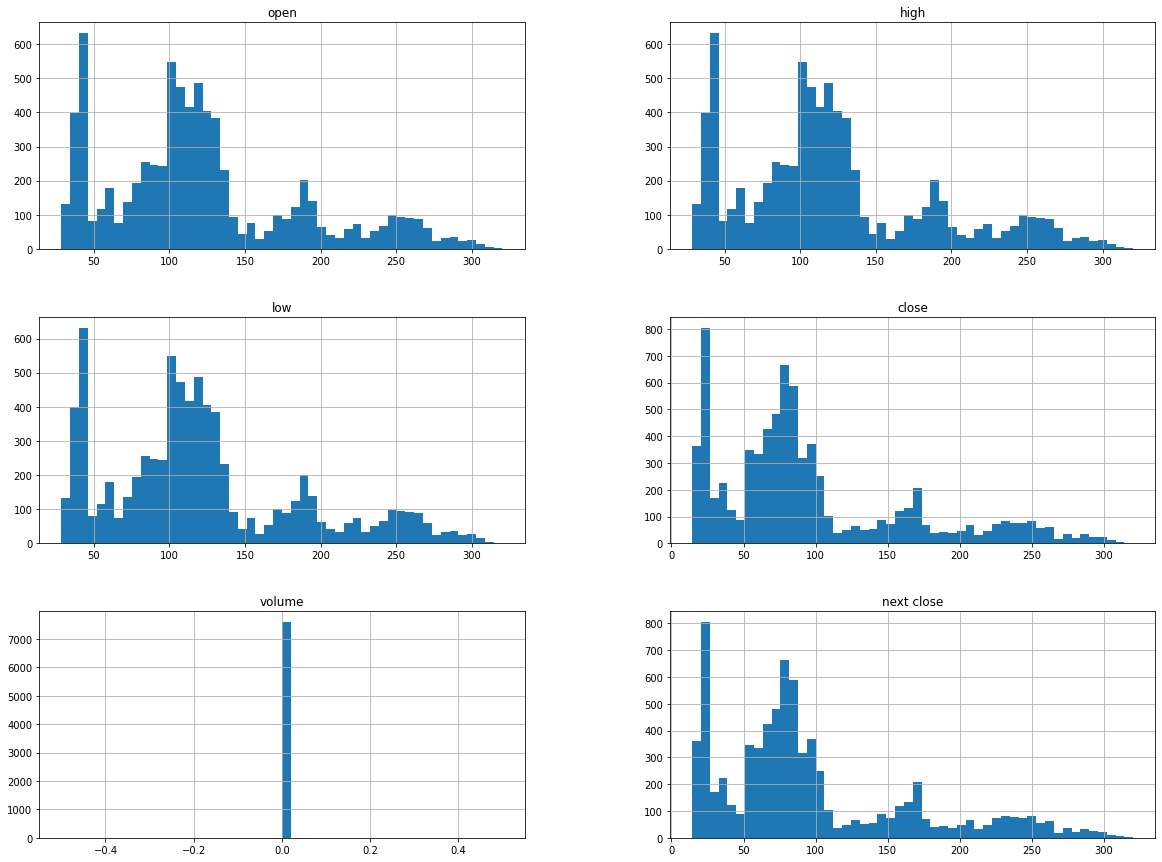

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
df.hist(bins=50, figsize=(20,15))

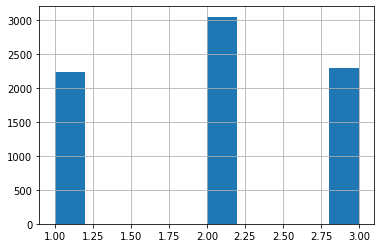

In [24]:
#use close and generate incidator feature to predict next close, but looks the data is not distribute evenly, use stratified 
'''
close is an important feature for prediction, but it is not evenly distribute, will affect the further ML, use stratify random split
divide close 3 group, low <60, medium 60-100, high >100  and randomize it
'''
import numpy as np
reg_df = df.copy()
reg_df["close cat"] = pd.cut(reg_df["close"],
                               bins=[0., 60, 100, np.inf],
                               labels=[1, 2, 3])

reg_df['close cat'].hist()


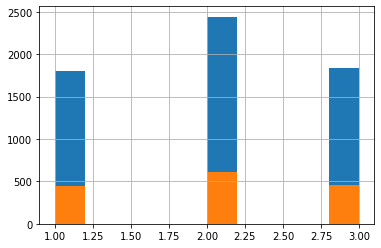

In [25]:
#stratified data split make data distribute evenly based on value
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) 
for train_index, test_index in split.split(reg_df, reg_df["close cat"]):
    strat_reg_train = reg_df.loc[train_index]
    strat_reg_test = reg_df.loc[test_index]

strat_reg_train['close cat'].hist()
strat_reg_test['close cat'].hist()

In [26]:
#drop close cat
for set_ in (strat_reg_train, strat_reg_test):
    set_.drop("close cat", axis=1, inplace=True)

print (strat_reg_train.shape)
print (strat_reg_test.shape)
strat_reg_train.head()

(6077, 7)
(1520, 7)


date        open        high         low       close  volume  \
3715  2005-04-25  106.269997  106.269997  106.269997   75.551331       0   
3611  2004-11-23  108.110001  108.110001  108.110001   75.959526       0   
5029  2010-07-14  100.260002  100.260002  100.260002   79.585953       0   
6737  2017-04-26  217.610001  217.610001  217.610001  199.995209       0   
3272  2003-07-22   90.529999   90.529999   90.529999   61.865421       0   

      next close  
3715   74.875954  
3611   76.275711  
5029   79.681183  
6737  200.123886  
3272   61.899574

In [27]:
def generateTestcolumn(df):
    dfx = df.drop('next close', axis =1)
    dfy = df['next close']
    return dfx, dfy

#split predit and label
reg_train_x, reg_train_y = generateTestcolumn (strat_reg_train)
reg_test_x, reg_test_y = generateTestcolumn (strat_reg_test)
print (reg_train_x.shape)
print (reg_test_x.shape)
print (reg_train_y.shape)
print (reg_test_y.shape)
reg_train_x.head()


(6077, 6)
(1520, 6)
(6077,)
(1520,)


date        open        high         low       close  volume
3715  2005-04-25  106.269997  106.269997  106.269997   75.551331       0
3611  2004-11-23  108.110001  108.110001  108.110001   75.959526       0
5029  2010-07-14  100.260002  100.260002  100.260002   79.585953       0
6737  2017-04-26  217.610001  217.610001  217.610001  199.995209       0
3272  2003-07-22   90.529999   90.529999   90.529999   61.865421       0

In [28]:
#create pipeline to facillitate data process  and machine learning
# in this case I use svm algorithm, but any applicable one should be fine

from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn import svm

num_pipeline = Pipeline([
        
        ('custom_transform', CreateSignal()),               #add features
         ('imputer', SimpleImputer(strategy="median")),     #replace null with median
         ('std_scaler', StandardScaler()),                  #scale data 
        
    ])

svr_pipeline = Pipeline([
    ('num_pip', num_pipeline),
    ('svr_reg', svm.SVR())
])




In [19]:
import time
from sklearn.model_selection import GridSearchCV
start_time = time.time()
grid_params_gs = [{
                      'svr_reg__C': [1, 3],
                      'svr_reg__kernel': ['linear', 'rbf'],
                      'num_pip__custom_transform__indicator':['SMA'],
                      'num_pip__custom_transform__function':[TA.SMA],
                      'num_pip__custom_transform__fast':  [int(x) for x in np.linspace(7, 50, num = 4)], 
                      'num_pip__custom_transform__slow':  [int(x) for x in np.linspace(50, 200, num = 4)], 

                    },
                  {
                  'svr_reg__C': [1, 3],
                  'svr_reg__kernel': ['linear', 'rbf'],
                  'num_pip__custom_transform__indicator':['RSI'],
                  'num_pip__custom_transform__function':[TA.RSI],
                  'num_pip__custom_transform__period':[7,14,21],
                  'num_pip__custom_transform__low':  [int(x) for x in np.linspace(7, 40, num = 4)], 
                  'num_pip__custom_transform__high':  [int(x) for x in np.linspace(50, 200, num = 4)], 

                },
 ]  



reg_train_y = reg_train_y.fillna(reg_train_y.median())
reg_gs = GridSearchCV(svr_pipeline, grid_params_gs)
reg_gs.fit(reg_train_x , reg_train_y)
print("Best Score: ", reg_gs.best_score_)
print("Best Params: ", reg_gs.best_params_)
print("--- %s seconds ---" % (time.time() - start_time))


Best Score:  0.9979794937468505
Best Params:  {'num_pip__custom_transform__function': <bound method TA.RSI of <class 'finta.finta.TA'>>, 'num_pip__custom_transform__high': 50, 'num_pip__custom_transform__indicator': 'RSI', 'num_pip__custom_transform__low': 7, 'num_pip__custom_transform__period': 7, 'svr_reg__C': 1, 'svr_reg__kernel': 'linear'}
--- 1226.2135081291199 seconds ---
